In [1]:
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#  Particle diatribution over grid
def initialPos(charge, numberofparticle, numberOfgridcell, gridSize, mass):
    initposition = np.random.uniform(
        0, numberOfgridcell*gridSize, size=(numberofparticle, 3))
    initposition[:, 2] = 0
    chargeAnsMass = np.ones([numberofparticle, 2])
    chargeAnsMass[:, 0] = charge
    chargeAnsMass[:, 1] = mass
    return initposition, chargeAnsMass


In [23]:
def particleDistribution(numberOfparticleinEachCell, numberOfgridcell, charge1, charge2, mass1, mass2):
    # initposition = np.empty(numberOfgridcell*numberOfgridcell*numberOfparticleinEachCell)
    pos = np.array([[0, 0, 0]])
    qANDm = np.array([[0, 0]])
    for i in range(numberOfgridcell):
        for j in range(numberOfgridcell):
            for n in range(numberOfparticleinEachCell):
                x = np.random.uniform(i, i+1)
                y = np.random.uniform(j, j+1)
                if n < numberOfparticleinEachCell/2:
                    q = charge1
                    m = mass1
                else:
                    q = charge2
                    m = mass2
                positionIngrid = np.array([[x, y, 0]])
                chargeAnsMass = np.array([[q, m]])
                pos = np.concatenate((pos, positionIngrid), axis=0)
                qANDm = np.concatenate((qANDm, chargeAnsMass), axis=0)
    return pos[1:], qANDm[1:]


# Charge density calculation using Cloud in Cell Algorithm
def chargeDensity(initposition, numberOfgridcell, chargeAnsMass):
    density = np.zeros([numberOfgridcell+1, numberOfgridcell+1])
    for i in range(len(initposition)):
        x = initposition[i][0]
        y = initposition[i][1]
        q = chargeAnsMass[0]
        i = int(x)
        j = int(y)

        w1 = (i+1-x)*(j+1-y)  # (i,j)
        w2 = (x-i)*(j+1-y)    # (i+1,j)
        w3 = (i+1-x)*(y-j)    # (i,j+1)
        w4 = (x-i)*(y-j)      # (i+1,j+1)

        density[i, j] += w1*q
        density[i+1, j] += w2*q
        density[i, j+1] += w3*q
        density[i+1, j+1] += w4*q

    return density.transpose()


# Electric Potential solver using finite difference method
def poissonSolver(density, numberOfgridcell):
    Nx = numberOfgridcell+2
    Ddiag = -4 * np.eye(Nx - 1)
    Dupper = np.diag([1] * (Nx - 2), 1)
    Dlower = np.diag([1] * (Nx - 2), -1)
    D = Ddiag + Dupper + Dlower
    Ds = [D] * (Nx - 1)
    A = block_diag(*Ds)
    I = np.ones((Nx - 1) * (Nx - 2))
    Iupper = np.diag(I, Nx - 1)
    Ilower = np.diag(I, -Nx + 1)
    A += Iupper + Ilower
    B = density.flatten()

    phi = np.linalg.solve(A, B)
    phi = phi.reshape(
        numberOfgridcell+1, numberOfgridcell+1)

    conductingPhi = np.zeros([numberOfgridcell+3, numberOfgridcell+3])
    conductingPhi[1:-1, 1:-1] = phi
    conductingPhi[0], conductingPhi[-1], conductingPhi[:, 0], conductingPhi[:, -
                                                                            1] = conductingPhi[1], conductingPhi[-2], conductingPhi[:, 1], conductingPhi[:, -2]

    return conductingPhi


# Function to find elctric field from solved potential
def elctricfieldsolver(phi, numberOfgridcell):
    electricfield_x = np.zeros([numberOfgridcell+1, numberOfgridcell+2])
    electricfield_y = np.zeros([numberOfgridcell+2, numberOfgridcell+1])
    # electricfield_z = np.zeros([numberOfgridcell+1, numberOfgridcell+1])

    for i in range(numberOfgridcell+1):
        for j in range(numberOfgridcell+2):
            electricfield_x[i, j] = phi[i+1, j+1] - phi[i+1, j]

    for i in range(numberOfgridcell+2):
        for j in range(numberOfgridcell+1):
            electricfield_y[i, j] = phi[i+1, j+1] - phi[i, j+1]

    return electricfield_x, electricfield_y

# Inverse CIC


def fieldAtparticlepos(initposition, electricfield):
    x = initposition[0]
    y = initposition[1]
    i = int(x)
    j = int(y)

    w1 = (i+1-x)*(j+1-y)  # (i,j)
    w2 = (i+1-x)*(y-j)    # (i,j+1)
    w3 = (x-i)*(j+1-y)    # (i+1,j)
    w4 = (x-i)*(y-j)      # (i+1,j+1)

    # i, j = j, i
    # return w1*electricfield[j, i] + w2*electricfield[j+1, i] + w3*electricfield[j, i+1] + w4*electricfield[j+1, i+1]
    return w1*electricfield[i, j] + w2*electricfield[i+1, j] + w3*electricfield[i, j+1] + w4*electricfield[i+1, j+1]

# Boris-Method Particle push


def BorisPush(inposition, invelocity, eField, extEfield, magneticfield, chargeAnsMass, dt, timeofrun):

    Ex = fieldAtparticlepos(inposition, eField[0])
    Ey = fieldAtparticlepos(inposition, eField[1])
    Ez = 0
    electricfield = np.array([Ex, Ey, Ez]) + extEfield

    numberOfitteration = int(timeofrun/dt)
    timeSteps = np.linspace(0, timeofrun, numberOfitteration)

    position = np.zeros([numberOfitteration, 3])
    velocity = np.zeros([numberOfitteration, 3])
    kinetic_energy = np.zeros(numberOfitteration)

    position[0] = inposition
    velocity[0] = invelocity
    # velocity[0] = invelocity*chargeAnsMass[0]

    kinetic_energy[0] = np.linalg.norm(velocity[0])

    t = (chargeAnsMass[0]*magneticfield/chargeAnsMass[1])*dt/2
    s = (2*t)/(1 + np.dot(t, t))

    for i in range(numberOfitteration-1):
        # Kick
        position_half = position[i] + velocity[i]*dt/2

        # Drift and rotation
        v_minus = velocity[i] + (chargeAnsMass[0] *
                                 electricfield/chargeAnsMass[1])*dt/2
        v_prime = v_minus + np.cross(v_minus, t)
        v_plus = v_minus + np.cross(v_prime, s)
        velocity[i+1] = v_plus + \
            (chargeAnsMass[0]*electricfield/chargeAnsMass[1])*dt/2

        # Kick
        position[i+1] = position_half + velocity[i+1]*dt/2
        # kinetic_energy[i+1] = np.linalg.norm(velocity[i+1])

    return position[-1], velocity[-1]


# field weighting
def FieldweightingX(x, y, Ex):
    if x < (int(x) + 0.5):
        i = int(x)
    else:
        i = int(x) + 1

    j = int(y)

    l1 = x - i + 0.5
    l3 = i + 0.5 - x
    l2 = y - j
    l4 = j + 1 - y

    Exw = Ex[j, i]*l3*l4 + Ex[j, i+1]*l1*l4 + \
        Ex[j+1, i]*l2*l3 + Ex[j+1, i+1]*l1*l2
    return Exw


def FieldweightingY(x, y, Ey):
    i = int(x)
    if y < (int(y) + 0.5):
        j = int(y)
    else:
        j = int(y) + 1

    l1 = x - i
    l3 = i + 1 - x
    l2 = y - j + 0.5
    l4 = j + 0.5 - y

    Eyw = Ey[j, i]*l3*l4 + Ey[j, i+1]*l1*l4 + \
        Ey[j+1, i]*l2*l3 + Ey[j+1, i+1]*l1*l2
    return Eyw


In [5]:
# Ex = fieldAtparticlepos(initposition[0], np.array(
#     [electricfield_x, electricfield_y])[0])
# Ey = fieldAtparticlepos(initposition[0], np.array(
#     [electricfield_x, electricfield_y])[1])
# Ez = 0
# electricfield = np.array([Ex, Ey, Ez])
# electricfield


In [5]:
def plotParticleOverGrid(position, x, y, i=1, s=0.5):
    # plt.figure(figsize=(12, 12), dpi=100)

    plt.plot(x, y, c='blue', alpha=0.1)
    plt.plot(y, x, c='blue', alpha=0.1)
    # plt.xticks(x)
    # plt.yticks(y)
    plt.ylim(len(x) + 0.5, -0.5)
    plt.scatter(position[:, 0], position[:, 1], s=s, c=position[:, 2], label=i)
    # plt.legend()
    # plt.colorbar()
    plt.show()


def plotDensity(x, y, density, numberOfgridcell):
    # plt.figure(figsize=(12, 12), dpi=100)
    # plt.grid()
    # plt.xticks(x)
    # plt.yticks(y)
    plt.imshow(density, extent=(0, numberOfgridcell, numberOfgridcell, 0))
    plt.colorbar()
    plt.show()


def plotpotentialofparticle(x, y, phi, numberOfgridcell):
    # plt.figure(figsize=(12, 12), dpi=100)
    # plt.grid()
    # plt.xticks(x)
    # plt.yticks(y)
    plt.imshow(phi, extent=(0, numberOfgridcell, numberOfgridcell, 0))
    plt.colorbar()
    plt.show()


def plotElectricField(electricfield, numberOfgridcell, gridSize, d=1):

    numberOfgridcell = numberOfgridcell+1
    x = np.linspace(0, numberOfgridcell*gridSize, numberOfgridcell)
    y = np.linspace(0, numberOfgridcell*gridSize, numberOfgridcell)
    x_grid, y_grid = np.meshgrid(x, y)
    # plt.figure(figsize=(12, 12), dpi=100)
    # plt.scatter(x_grid, y_grid, c='blue')
    plt.streamplot(x, y, electricfield[:, :, 0],
                   electricfield[:, :, 1], density=d)
    # plt.xticks(x)
    # plt.yticks(y)
    plt.ylim(numberOfgridcell+1 + 0.5, -0.5)
    plt.show()


## Two stream Instability

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_290940/3107248368.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  initposition[n], velocity[n] = BorisPush(initposition[n], velocity[n], np.array(
 39%|███▉      | 188/481 [00:06<00:09, 29.52it/s]


KeyboardInterrupt: 

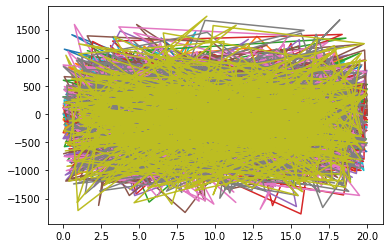

In [31]:
n = 500
boxSize = 20
initposition = np.random.uniform(0, boxSize, size=(n,3))
initposition[:,2] = 0
initposition[:,1] = boxSize/2
velocity = np.ones([n,3])*5
velocity[: int(n/2)] *= -1
velocity[:,1] = 0
velocity[:,2] = 0
Nx = 20
magneticfield = np.zeros(3)
chargeAnsMass = np.ones(2)
dt = 0.1
timeofrun = 50
gridSize = boxSize/Nx
extEfield = np.zeros(3)

for i in range(50):
    density = chargeDensity(initposition, Nx, chargeAnsMass)
    phi = poissonSolver(density, Nx)
    electricfield_x, electricfield_y = elctricfieldsolver(
        phi, Nx)
    for n in tqdm(range(n)):
        initposition[n], velocity[n] = BorisPush(initposition[n], velocity[n], np.array(
            [electricfield_x, electricfield_y]),extEfield, magneticfield, chargeAnsMass, dt, timeofrun)
        initposition[n, 0] = initposition[n, 0] % (
            gridSize*Nx)
        initposition[n, 1] = initposition[n, 1] % (
            gridSize*Nx)
    plt.plot(initposition[:,0], velocity[:,0])

    

In [5]:
# required constants
# mass = 1
charge1 = 1
mass1 = 1800
charge2 = -1
mass2 = 1

numberOfparticleinEachCell = 1
numberOfparticleinbeam = 1000
gridSize = 1
numberOfgridcell = 3
numberofparticle = numberOfparticleinEachCell * \
    numberOfgridcell*numberOfgridcell + 2*numberOfparticleinbeam
timeofrun = 0.1
dt = 0.01
magneticfield = np.array([0, 0, 0])
electricfield = np.array([0, 0, 0])
velocity = np.zeros([numberofparticle, 3])


velocity[-2*numberOfparticleinbeam:-numberOfparticleinbeam, 0] = -10000
velocity[-numberOfparticleinbeam:, 0] = 10000
# velocity[:,1] = 10

x = np.linspace(0, numberOfgridcell*gridSize, numberOfgridcell+1)
y = np.linspace(0, numberOfgridcell*gridSize, numberOfgridcell+1)
x_grid, y_grid = np.meshgrid(x, y)
# x, y = np.meshgrid(x, y)

initposition1, chargeAnsMass1 = initialPos(
    charge1, numberOfparticleinbeam, numberOfgridcell, gridSize, mass1)
initposition1[:, 1] = 7
initposition2, chargeAnsMass2 = initialPos(
    charge2, numberOfparticleinbeam, numberOfgridcell, gridSize, mass2)
initposition2[:, 1] = 13
initposition = np.concatenate((initposition1, initposition2), axis=0)


initposition3, chargeAnsMass3 = particleDistribution(
    numberOfparticleinEachCell, numberOfgridcell, charge1, charge2, mass1, mass2)

initposition = np.concatenate(
    (initposition1, initposition2, initposition3), axis=0)
chargeAnsMass = np.concatenate(
    (chargeAnsMass1, chargeAnsMass2, chargeAnsMass3), axis=0)

# initposition = initposition1
# density = chargeDensity(initposition, numberOfgridcell)


In [40]:
# initposition.shape


In [39]:
# chargeAnsMass


In [38]:
# plt.figure(figsize=(6, 6), dpi=100)
# plt.plot(x_grid, y_grid, c='b', alpha=0.3)
# plt.plot(y_grid, x_grid, c='b', alpha=0.3)
# plt.ylim(len(x) + 0.5, -0.5)

# # plt.scatter(initposition[-2*numberOfparticleinbeam:, 0], initposition[-2*numberOfparticleinbeam:, 1], c= initposition[-2*numberOfparticleinbeam:,2], cmap = 'rainbow', s = 1)
# plt.scatter(initposition[:, 0], initposition[:, 1], c=chargeAnsMass[:,0], cmap = 'rainbow', s = 1)
# plt.show()

# # plt.figure(figsize=(6, 6), dpi=100)
# # plt.plot(x_grid,y_grid, c='b', alpha=0.3)
# # plt.plot(y_grid,x_grid, c='b', alpha=0.3)
# # plt.scatter(x_grid,y_grid, s= np.abs(density)*200, c=density)
# # plt.colorbar()
# # plt.show()


In [ ]:
# Main PIC loop
N = 50

for i in range(N):
    density = chargeDensity(initposition, numberOfgridcell, chargeAnsMass)
    phi = poissonSolver(density, numberOfgridcell)
    electricfield_x, electricfield_y = elctricfieldsolver(
        phi, numberOfgridcell)
    for n in tqdm(range(numberofparticle)):
        initposition[n], velocity[n] = BorisPush(initposition[n], velocity[n], np.array(
            [electricfield_x, electricfield_y]), magneticfield, chargeAnsMass[n], dt, timeofrun)
        initposition[n, 0] = initposition[n, 0] % (
            gridSize*numberOfgridcell)
        initposition[n, 1] = initposition[n, 1] % (
            gridSize*numberOfgridcell)

    # plt.figure(figsize=(6, 6), dpi=100)
    # plt.plot(x_grid, y_grid, c='b', alpha=0.3)
    # plt.ylim(len(x) + 0.5, -0.5)
    # plt.plot(y_grid, x_grid, c='b', alpha=0.3)
    # plt.scatter(initposition[:, 0], initposition[:, 1], c= initposition[:,2], s=1, cmap = 'rainbow')
    # plt.show()
    # plt.figure(figsize=(10, 10), dpi=150)
    # plt.scatter(initposition[:,0], velocity[:,0])
    # plt.show()

    plt.figure(figsize=(6, 6), dpi=100)
    plt.plot(x_grid, y_grid, c='b', alpha=0.3)
    plt.plot(y_grid, x_grid, c='b', alpha=0.3)
    plt.ylim(len(x) + 0.5, -0.5)
    plt.scatter(initposition[:, 0], initposition[:, 1],
                c=chargeAnsMass[:, 0], cmap='rainbow', s=1)
    plt.show()


In [15]:
# x = np.linspace(0, 100, 101)
# y = x**2

# fig = plt.figure(figsize=(10, 10))
# ax1 = plt.subplot2grid((15, 15), (0, 0), colspan=10, rowspan=4)
# ax2 = plt.subplot2grid((15, 15), (4, 0), colspan=10, rowspan=10)
# ax3 = plt.subplot2grid((15, 15), (4, 10), colspan=4, rowspan=10)
# ax1.plot(x, y)
# ax3.plot(y, y)
# ax2.scatter(y, x, c=x)
# ax3.set_yticks([])
# ax1.set_xticks([])
# plt.colorbar()
# plt.show()


## Simple Hormonic Motion


In [69]:
charge1 = 1
charge2 = -50

mass1 = 1
mass2 = 1

numberOfgridcell = 5
numberofparticle = 1

# initposition = np.array([[2.5,2.5 , 0]])
# initposition = np.array([[2, 2, 0], [2, 3, 0]])
initposition = np.array([[2, 2, 0]])
# initposition = np.array([[numberOfgridcell/2, numberOfgridcell/2, 0], [0.5, numberOfgridcell/2, 0]])


timeofrun = 0.1
dt = 0.01
gridSize = 1

x = np.linspace(0, numberOfgridcell*gridSize, numberOfgridcell+1)
y = np.linspace(0, numberOfgridcell*gridSize, numberOfgridcell+1)

x_grid, y_grid = np.meshgrid(x, y)

magneticfield = np.array([0, 0, 0])
extEfield = np.array([0, 0, 0])
velocity = np.zeros([numberofparticle, 3])

# chargeAnsMass = np.array([[charge1, mass1], [charge2, mass2]])
chargeAnsMass = np.array([[charge1, mass1]])


In [70]:
density = chargeDensity(initposition, numberOfgridcell, chargeAnsMass)
phi = poissonSolver(density, numberOfgridcell)
electricfield_x, electricfield_y = np.gradient(phi)[0], np.gradient(phi)[1]

In [88]:
a = np.array([1,2,4,8,16,32,64,128])
np.gradient(a,2)

array([ 0.5 ,  0.75,  1.5 ,  3.  ,  6.  , 12.  , 24.  , 32.  ])

/tmp/ipykernel_5274/2400272777.py:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(r, k/r, label = '1/r');


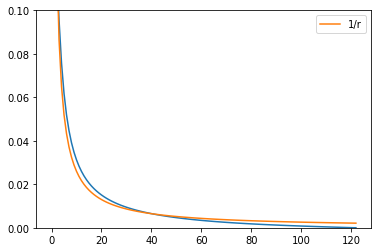

In [59]:
r = np.linspace(0,122,123)
k = 0.26
l = 2
plt.ylim(0, 0.1)
plt.plot(r, abs(phi[50,:]));
plt.plot(r, k/r, label = '1/r');
# plt.plot(r, l/r**2, label = '1/r^2');
plt.legend();

In [14]:
# plt.figure(figsize=(10,6), dpi = 100)
# plt.plot(x, abs(phi[int(numberOfgridcell/2)][1:-1]))
# plt.ylabel('Phi')
# plt.xlabel('x')
# plt.plot(x, 10/x)

In [20]:
np.round(phi[1:-1,1:-1], 2)

array([[-0.03, -0.05, -0.07, -0.07, -0.04, -0.02],
       [-0.05, -0.12, -0.18, -0.14, -0.09, -0.04],
       [-0.07, -0.18, -0.37, -0.25, -0.12, -0.05],
       [-0.07, -0.14, -0.25, -0.19, -0.11, -0.05],
       [-0.04, -0.09, -0.12, -0.11, -0.07, -0.03],
       [-0.02, -0.04, -0.05, -0.05, -0.03, -0.02]])

In [10]:
test = np.gradient(phi)
np.round(test,2)

array([[[  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [ -1.11,  -1.11,  -2.25,  -3.1 ,  -2.52,  -1.6 ,  -0.76,  -0.76],
        [ -2.32,  -2.32,  -5.18,  -8.36,  -5.77,  -3.24,  -1.43,  -1.43],
        [ -2.  ,  -2.  ,  -5.93, -17.01,  -6.85,  -2.66,  -0.97,  -0.97],
        [  0.26,   0.26,   0.48,   0.59,   0.56,   0.42,   0.22,   0.22],
        [  2.58,   2.58,   6.99,  18.32,   8.07,   3.56,   1.43,   1.43],
        [  1.52,   1.52,   3.51,   5.98,   3.92,   2.12,   0.92,   0.92],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ]],

       [[  0.  ,  -0.88,  -1.37,  -0.25,   0.87,   1.38,   0.74,   0.  ],
        [  0.  ,  -0.88,  -1.37,  -0.25,   0.87,   1.38,   0.74,   0.  ],
        [  0.  ,  -2.02,  -3.36,  -0.52,   2.37,   3.14,   1.59,   0.  ],
        [  0.  ,  -3.74,  -7.41,  -0.84,   5.99,   5.72,   2.55,   0.  ],
        [  0.  ,  -5.95, -18.37,  -1.44,  16.73,   9.02,   3.28,   0.  ],
        [  0.  ,  -3.52,  -7.08,  -0

In [22]:
Ex = np.round(electricfield_x, 2)
Ex

array([[ 0.  , -0.03, -0.02,  0.01,  0.02,  0.02,  0.  ],
       [ 0.  , -0.06, -0.06,  0.03,  0.06,  0.05,  0.  ],
       [ 0.  , -0.1 , -0.2 ,  0.12,  0.12,  0.07,  0.  ],
       [ 0.  , -0.08, -0.1 ,  0.06,  0.08,  0.06,  0.  ],
       [ 0.  , -0.04, -0.04,  0.02,  0.04,  0.04,  0.  ],
       [ 0.  , -0.02, -0.01,  0.  ,  0.01,  0.02,  0.  ]])

In [21]:
Ey = np.round(electricfield_y, 2)
Ey

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.03, -0.06, -0.1 , -0.08, -0.04, -0.02],
       [-0.02, -0.06, -0.2 , -0.1 , -0.04, -0.01],
       [ 0.01,  0.03,  0.12,  0.06,  0.02,  0.  ],
       [ 0.02,  0.06,  0.12,  0.08,  0.04,  0.01],
       [ 0.02,  0.05,  0.07,  0.06,  0.04,  0.02],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [47]:
x = 2.49
y = 1.45

i = int(x)
if y < (int(y) + 0.5):
    j = int(y)
else:
    j = int(y) + 1

l1 = x - i
l3 = i + 1 - x
l2 = y - j + 0.5
l4 = j + 0.5 - y

In [63]:
-14.7*0.5*0.05 - 14.5*0.5*0.05 + 0.3*0.95*0.5 + 0.2*0.5*0.95

-0.49250000000000005

In [23]:
FieldweightingY(2.2, 2.2, electricfield_y)
FieldweightingY(numberOfgridcell/2+.5, 10, electricfield_y)

IndexError: index 10 is out of bounds for axis 0 with size 7

In [66]:
FieldweightingX(10, numberOfgridcell/2+.5, electricfield_x)
FieldweightingX(numberOfgridcell/2+.5, 10, electricfield_x)


0.018729101909503054

In [63]:
# plt.streamplot(x, y, electricfield_x,electricfield_y)

In [64]:
# field weighting
def FieldweightingX(x, y, Ex):
    if x <= (int(x) + 0.5):
        i = int(x)
    else:
        i = int(x) + 1

    j = int(y)

    l1 = x - i + 0.5
    l3 = i + 0.5 - x
    l2 = y - j
    l4 = j + 1 - y

    Exw = Ex[j, i]*l3*l4 + Ex[j, i+1]*l1*l4 + \
        Ex[j+1, i]*l2*l3 + Ex[j+1, i+1]*l1*l2
    return Exw


def FieldweightingY(x, y, Ey):
    i = int(x)
    if y <= (int(y) + 0.5):
        j = int(y)
    else:
        j = int(y) + 1

    l1 = x - i
    l3 = i + 1 - x
    l2 = y - j + 0.5
    l4 = j + 0.5 - y

    Eyw = Ey[j, i]*l3*l4 + Ey[j, i+1]*l1*l4 + \
        Ey[j+1, i]*l2*l3 + Ey[j+1, i+1]*l1*l2
    return Eyw

In [49]:
initposition

array([[2.49, 1.45, 0.  ]])

In [128]:
N = 3
phi =  np.random.randint(0,10, size=(N+2,N+2))
phi[0], phi[-1], phi[:,0], phi[:,-1] = phi[1], phi[-2], phi[:,1], phi[:,-2]
phi

array([[7, 7, 0, 6, 6],
       [7, 7, 0, 6, 6],
       [7, 7, 8, 3, 3],
       [1, 1, 2, 2, 2],
       [1, 1, 2, 2, 2]])

In [129]:
b = np.zeros([N+2, N+2])
# electricfield_y = np.zeros([N+3, N+3])
# electricfield_z = np.zeros([N+1, N+1])

for i in range(1,N+1):
    for j in range(N+1):
        b[i,j] = phi[i, j+1] - phi[i, j]
b

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0., -7.,  6.,  0.,  0.],
       [ 0.,  1., -5.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

3

In [ ]:
def forceWeigting(p, E):
    

    Eap = 0
    return Eap

In [24]:
# print(fieldAtparticlepos(np.array([2, 2.5, 0]), electricfield_x))

11.896363636363638


In [214]:
print(np.round(electricfield_x, 3))

[[ -1.91   -1.508  -0.35    0.772   1.212   1.25    1.215]
 [ -4.367  -3.64   -0.666   2.226   2.827   2.61    2.434]
 [ -8.05   -7.907  -0.898   5.969   5.261   4.041   3.531]
 [-12.818 -19.441  -0.987  17.289   8.205   5.008   4.094]
 [ -8.05   -7.907  -0.898   5.969   5.261   4.041   3.531]
 [ -4.367  -3.64   -0.666   2.226   2.827   2.61    2.434]
 [ -1.91   -1.508  -0.35    0.772   1.212   1.25    1.215]]


In [217]:
a = np.array([2,3,0])
np.round(fieldAtparticlepos(initposition[0], electricfield_y),3)

0.0

In [203]:
# initposition[0]

array([3, 2, 0])

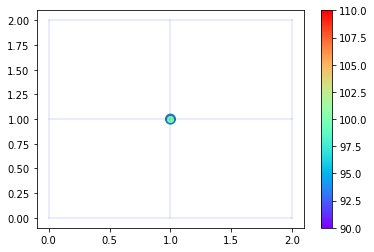

In [14]:
plt.plot(x_grid, y_grid, c='b', alpha=0.1)
plt.plot(y_grid, x_grid, c='b', alpha=0.1)
plt.scatter(x_grid, y_grid, s = abs(density))
plt.scatter(initposition[:, 0], initposition[:, 1],
            c=chargeAnsMass[:, 0], cmap='rainbow')
plt.colorbar();

In [ ]:
# # Main PIC loop
# N = 100

# # plt.figure(figsize=(10, 10), dpi=150)
# # print(initposition)
# for i in tqdm(range(N)):
#     density = chargeDensity(initposition, numberOfgridcell, chargeAnsMass)
#     phi = poissonSolver(density, numberOfgridcell)
#     electricfield_x, electricfield_y = elctricfieldsolver(
#         phi, numberOfgridcell)
#     eField = np.array([electricfield_x, electricfield_y])
#     for n in (range(1, 2)):
#         initposition[n], velocity[n] = BorisPush(
#             initposition[n], velocity[n], eField, extEfield, magneticfield, chargeAnsMass[n], dt, timeofrun)
#         initposition[n, 0] = initposition[n, 0] % (gridSize*numberOfgridcell)
#         initposition[n, 1] = initposition[n, 1] % (gridSize*numberOfgridcell)

#     plt.plot(x_grid, y_grid, c='b')
#     plt.plot(y_grid, x_grid, c='b')
#     plt.scatter(initposition[:, 0], initposition[:, 1],
#                 c=chargeAnsMass[:, 0], cmap='rainbow')
#     # plt.show()
#     print(fieldAtparticlepos(initposition[1], electricfield_y))
#     # print(eField)


In [180]:
np.round(phi,0)

newx
newy = np.linspace(0.5)

array([[ -2.,  -5.,  -7.,  -9.,  -7.,  -5.,  -2.],
       [ -4.,  -9., -15., -22., -15.,  -9.,  -4.],
       [ -5., -12., -23., -48., -23., -12.,  -5.],
       [ -5., -10., -17., -24., -17., -10.,  -5.],
       [ -4.,  -7., -11., -13., -11.,  -7.,  -4.],
       [ -2.,  -5.,  -7.,  -7.,  -7.,  -5.,  -2.],
       [ -1.,  -2.,  -3.,  -3.,  -3.,  -2.,  -1.]])